In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
import matplotlib.patches as patches
from PIL import Image
from skimage.external import tifffile as tif
import PIL
from PIL import TiffImagePlugin
import matplotlib.ticker as ticker
from PIL import Image
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
#Update dataset folder to process individual dataset
database="100" # datbase folder
bg="dataset/"+database+"/bg.png"
qPALM="dataset/"+database+"/particles.csv" # qPALM tracking data
max_stack=200 # Maximum number of frames in each sub ROI tiff
min_stack=30 # Minumum number of frames in each sub ROI tiff
W=1024 # Input microscopy image width
H=1024  # Input microscopy image height

In [4]:
particles=pd.read_csv(qPALM)
X=particles.drop('fno',axis=1)
X=X.drop('id',axis=1)

In [5]:
X=X.as_matrix()

D:\Anaconda3\envs\nanoscopy\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


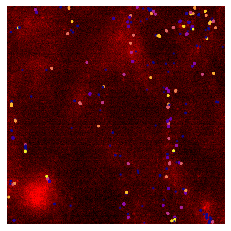

In [8]:
# cluster the data. This can be replaced by Tracking algorithm
dbscan = DBSCAN(eps=2, min_samples = 10)
clusters = dbscan.fit_predict(X)
# plot the cluster assignments
plt.scatter(particles['x'].T, particles['y'].T, c=clusters, s=1,cmap="plasma")
img = plt.imread(bg)
plt.imshow(img, cmap=plt.get_cmap('gray'), zorder=0)
plt.axis('off')
plt.show()
#print(clusters)

In [9]:
#Save the clustering results
from numpy import savetxt
savetxt('data.csv', clusters, delimiter=',')

In [10]:
import os
#grab last 4 characters of the file name:
def last_4chars(x):
    return(x[-4:])
imgName=[]
tiff_dir="dataset/"+database+"/png/"
file_list = os.listdir(tiff_dir)
for filename in sorted(file_list, key = last_4chars):
    imgName.append(filename)

In [11]:
track="dataset/"+database+"/track.csv"
particles=pd.read_csv(track)
#print(particles.shape)
t=particles[particles['cluster']==1]
fno=t['fno']
#print(fno)

D:\Anaconda3\envs\nanoscopy\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


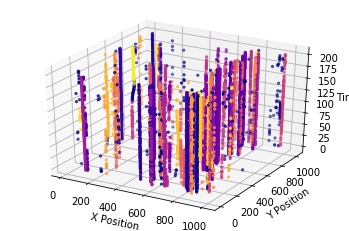

In [12]:
# Show the tracks
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection="3d")
data_3d=particles.drop('id',axis=1)
data_3d=data_3d.as_matrix()
ax.scatter3D(data_3d[:,0],data_3d[:,1],data_3d[:,2],marker='.',c=clusters,cmap="plasma")
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Time')

plt.show()

In [13]:
# Extract ROIs and sub ROIs
class ROI():
    def __init__(self, roiId, subId, xmin, ymin, xmax, ymax,startF,endF):
        self.roiId=roiId
        self.subId=subId
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.startF = startF
        self.endF = endF

In [15]:
allRoi=[]
data_cluster=np.array([data_3d[:,0],data_3d[:,1],data_3d[:,2],clusters]).T
total_cluster=max(clusters)
for i in range(0,total_cluster):
    temp_roi=data_cluster[data_cluster[:,3]==i]
    
    max_t=max(temp_roi[:,2])
    min_t=min(temp_roi[:,2])

    l,_=temp_roi.shape
    temp=data_cluster[:,3]
    max_frame=max(temp_roi[:,2])
    total_stack=max_frame-min_t
    sub_roi=int(total_stack/max_stack)
    for j in range(0,sub_roi-1):
        start_t=int(j*max_stack)
        if(int((j+1)*max_stack)>l):
            end_t=int(l)
        else:
            end_t=int((j+1)*max_stack)
        
        if(end_t-start_t>=min_stack):
            max_x=max(temp_roi[start_t:end_t,0])
            min_x=min(temp_roi[start_t:end_t,0])
            max_y=max(temp_roi[start_t:end_t,1])
            min_y=min(temp_roi[start_t:end_t,1])
            allRoi.append(ROI(int(i+1),int(j+1),int(min_x),int(min_y),int(max_x),int(max_y),min_t+start_t,min_t+end_t))

In [16]:
import os
#grab last 4 characters of the file name:
def last_4chars(x):
    return(x[-4:])
imgName=[]
tiff_dir="dataset/"+database+"/tif/"
file_list = os.listdir(tiff_dir)
for filename in sorted(file_list, key = last_4chars):
    imgName.append(filename)

In [17]:
#Output folders and dataset folders
output_dir="dataset/"+database+"/output/"
tiff_dir="dataset/"+database+"/tif/"

In [203]:
spatial_pad=6
#with open(tiff_file) as fp:
#    for i, line in enumerate(fp):
#        imgName.append(line.rstrip("\n\r"))
tid=1
for r in allRoi:
    track_start=r.startF
    track_end=r.endF
    roiId=r.roiId
    subId=r.subId
    j=0
    with PIL.TiffImagePlugin.AppendingTiffWriter(output_dir+str(roiId)+'_'+str(subId)+'.tiff',True) as tf:
            count=0
            for j in range(int(track_start),int(track_end)):
                imf=tiff_dir+str(imgName[int(j-1)])
                timg=Image.open(imf)
                if(r.xmin-spatial_pad<0):
                    xmin=0
                else:
                    xmin=r.xmin-spatial_pad
                    
                if(r.ymin-spatial_pad<0):
                    ymin=0
                else:
                    ymin=r.ymin-spatial_pad
                
                
                if(r.xmax+spatial_pad>W):
                    xmax=W
                else:
                    xmax=r.xmax+spatial_pad
                    
                if(r.ymax+spatial_pad>H):
                    ymax=H
                else:
                    ymax=r.ymax+spatial_pad
                    
                cropped_image = timg.crop((xmin,ymin,xmax,ymax))
                cropped_image.save(tf)
                tf.newFrame()
                count=count+1
                if(count>=max_stack):
                    tid
                    break;
    tid=tid+1